In [4]:
# # bolier plate

# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir("/content/drive/MyDrive/cs330")

In [5]:
import warnings 

warnings.simplefilter("ignore")


## Setup

You will need to make a copy of this Colab notebook in your Google Drive before you can edit the homework files. You can do so with **File &rarr; Save a copy in Drive**.


In [1]:
from typing import *
import numpy as np
import os
import random
import tensorflow as tf
from scipy import misc

2022-10-03 23:15:02.612855: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 23:15:03.212662: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-03 23:15:03.212745: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-03 23:15:03.264911: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-03 23:15:04.235736: W tensorflow/stream_executor/platform/de

In [7]:
from pathlib import Path

__dirname = Path("__file__").parent
__dirname
paths = [ p for p in __dirname.glob("omniglot_resized/Atlantean/*")]
labels = [i for i in range(len(paths))]

In [8]:
from get_images import get_images
images_labels: List[Tuple[int, str]] = get_images(
    paths=paths,
    labels=labels,
)


* `images_labels` returns `List[Tuple[int, str]]` list of tuple of integer and string.

In [9]:
images_labels[0]

(6, 'omniglot_resized/Atlantean/character08/1018_11.png')

uint8
(28, 28)


<AxesSubplot:>

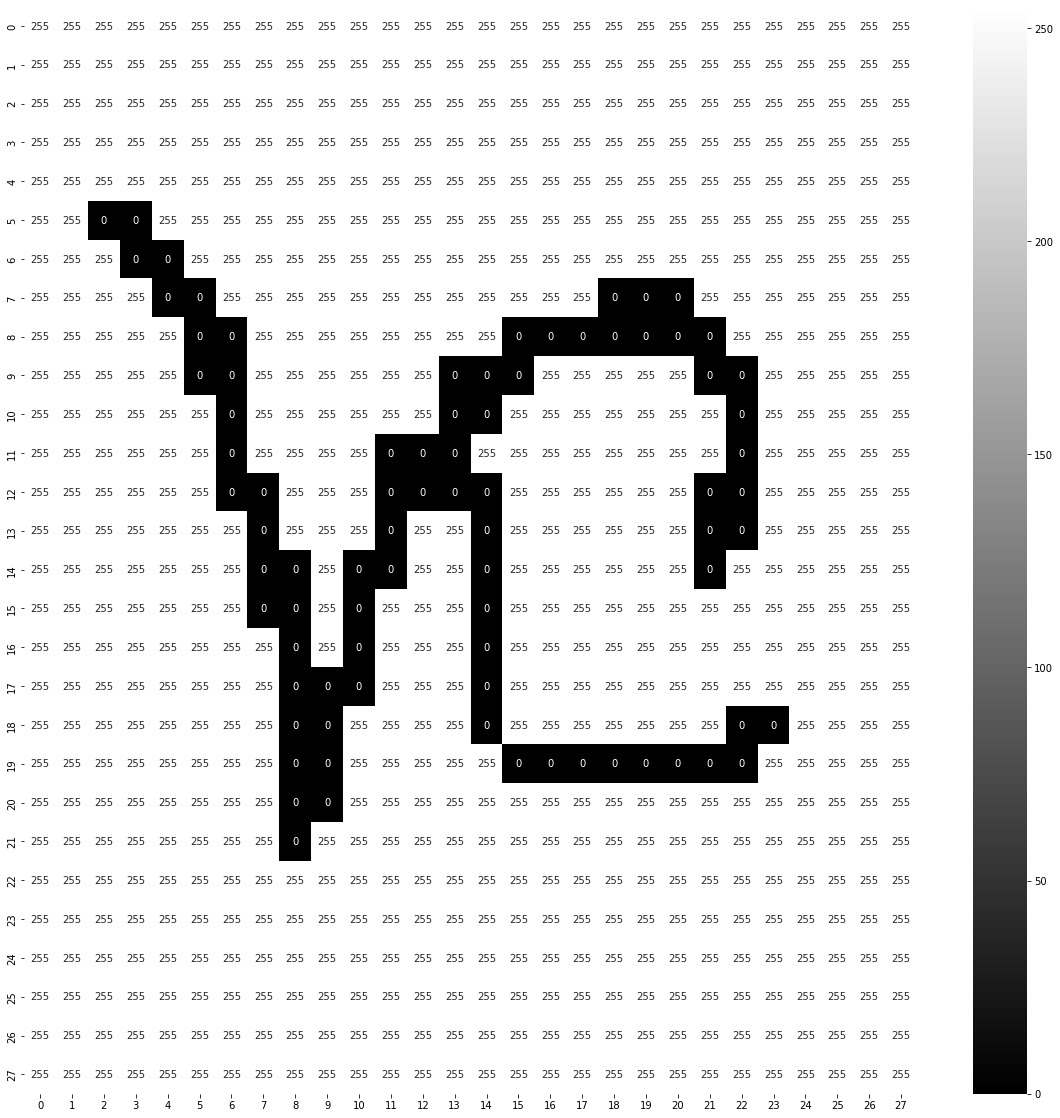

In [10]:
import matplotlib.pyplot as plt
import seaborn
import imageio


label, filename  = images_labels[0]
image = imageio.imread(filename)
print(image.dtype)
print(image.shape)

fig, ax = plt.subplots(figsize=(20,20))
seaborn.heatmap(image, cmap="gray", fmt="d", annot=True, ax=ax)

<AxesSubplot:>

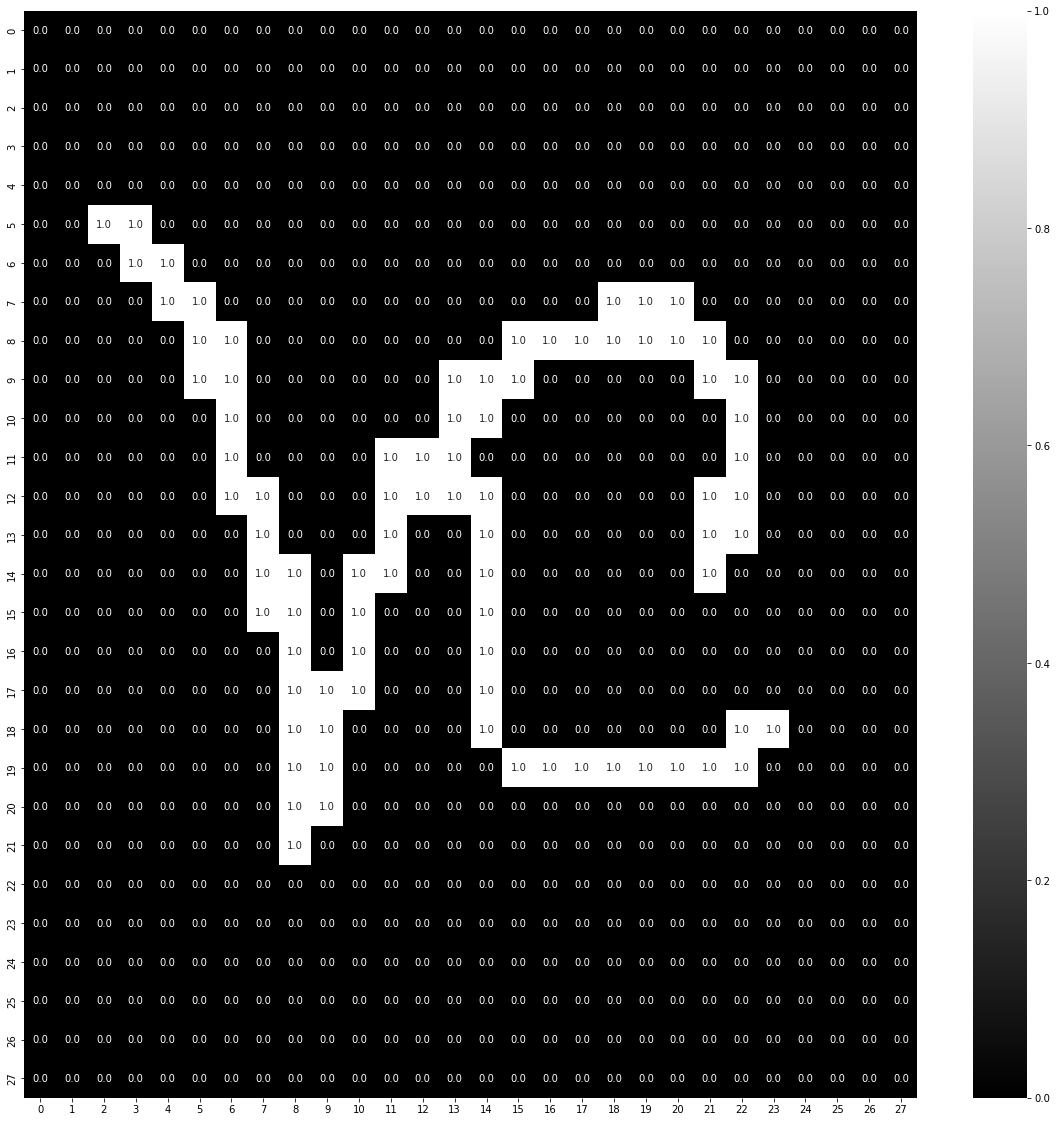

In [11]:
from image_file_to_array import image_file_to_array

fig, ax = plt.subplots(figsize=(20,20))

seaborn.heatmap(
    image_file_to_array(
        filename=filename,
        dim_input=28*28,
    ).reshape(28, 28), 
    cmap="gray", 
    fmt=".1f", 
    annot=True, 
    ax=ax,
)    

In [357]:
from pathlib import Path
import random
from typing import *

class DataGenerator(object):
    """
    Data Generator capable of generating batches of Omniglot data.
    A "class" is considered a class of omniglot digits.
    """

    def __init__(
        self,
        num_classes: int,
        num_samples_per_class: int,
        data_folder: str = "./omniglot_resized",
        img_size=(28, 28),
    ):
        """
        Args:
            num_classes: Number of classes for classification (K-way)
            num_samples_per_class: num samples to generate per class in one batch
            batch_size: size of meta batch size (e.g. number of functions)
        """


        self.K = num_samples_per_class
        self.N = num_classes
        self.img_size: Tuple[int, int] = img_size
        self.dim_input = np.prod(self.img_size)
        self.dim_output = self.num_classes

        tasks = []

        for task_folder in Path(data_folder).glob("*"):
            if task_folder.is_dir():
                char_folders = []
                for char_folder in task_folder.glob("*"):
                    if char_folder.is_dir():
                        char_folders.append(char_folder)

        random.seed(1)
        random.shuffle(character_folders)
        num_val = 100
        num_train = 1100
        self.metatrain_character_folders: List[Path] = character_folders[:num_train]
        self.metaval_character_folders: List[Path] = character_folders[
            num_train : num_train + num_val
        ]
        self.metatest_character_folders: List[Path] = character_folders[num_train + num_val :]


    def sample_batch(self, batch_type, batch_size, one_hot=True):
        """
        Samples a batch for training, validation, or testing
        Args:
            batch_type: train/val/test
        Returns:
            A a tuple of (1) Image batch and (2) Label batch where
            image batch has shape [B, K, N, 784] and label batch has shape [B, K, N, N]
            where B is batch size, K is number of samples per class, N is number of classes
        """
        if batch_type == "train":
            folders = self.metatrain_character_folders
        elif batch_type == "val":
            folders = self.metaval_character_folders
        else:
            folders = self.metatest_character_folders

        N: int = self.num_classes
        K: int = self.num_samples_per_class
        
        all_image_batches = []
        all_label_batches = []

        for i, char_img_folder in enumerate(folders): 
            if one_hot:
                label = np.zeros(shape=(K, self.num_classes))
                label[:,i % N] = 1
            else :
                label = np.full(shape=K, fill_value= i%N)
            sample_img_paths: List[Path] = [p for p in char_img_folder.glob("*.png")]
            random.shuffle(sample_img_paths)

            all_image_batches.append(
                np.stack([
                    image_file_to_array(sample_img_paths.pop()) for _ in range(K)
                ])
            )
            all_label_batches.append(label)

        all_image_batches = np.stack(all_image_batches)[:1100 - 1100%(N*batch_size*K)]
        all_label_batches = np.stack(all_label_batches)[:1100 - 1100%(N*batch_size*K)]

        all_image_batches = all_image_batches.reshape(-1, batch_size, N, K, 784) 
        all_image_batches = np.swapaxes(all_image_batches, 2, 3)
        if one_hot:
            all_label_batches = all_label_batches.reshape(-1, batch_size, N, K, N)
        else : 
            all_label_batches = all_label_batches.reshape(-1, batch_size, N, K)
        all_label_batches = np.swapaxes(all_label_batches, 2, 3)


        return (
            all_image_batches.astype(np.float32),
            all_label_batches.astype(np.float32),
        )



* image batch has shape `[B, K, N, 784]` and label batch has shape `[B, K, N, N]` where B is batch size, K is number of samples per class, N is number of classes

In [358]:
data_generator = DataGenerator(
    num_classes=4,
    num_samples_per_class=3,
)

In [379]:
def create_meta_trainset(all_image_batches, all_label_batches, ):
    num_batches, B, K, N, d = all_image_batches.shape
    train_labels = np.concatenate([
            all_label_batches[:, :, :-1], 
            np.zeros_like(all_label_batches[:, :, -1:]) 
        ], 
        axis=2,
    )
    meta_labels = np.argmax(all_label_batches[:,:,-1,:], axis=-1)

    meta_inputs = np.concatenate([all_image_batches, train_labels], axis=-1)
    meta_inputs = meta_inputs.reshape(num_batches, B, -1, d + N)
    return meta_inputs, meta_labels,




In [380]:
meta_inputs, meta_labels = create_meta_trainset(*data_generator.sample_batch(
    batch_type="train", 
    batch_size=16, 
    one_hot=True,
))

In [390]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
class MANN(nn.Module):
    def __init__(self, num_classes, num_samples, embed_size=784):
        super(MANN, self).__init__()
        self.num_classes = num_classes
        self.num_samples = num_samples
        self.embed_size = embed_size
        self.lstm1 = nn.LSTM(embed_size+num_classes, 128) #Pytorch always has return_sequences=True
        self.lstm2 = nn.LSTM(128, num_classes)

    def forward(self, inputs):
        x, _ = self.lstm1(inputs)
        x, _ = self.lstm2(x)
        # last_n_step_logits = x[-self.num_classes:].transpose(0,1).reshape(-1, self.num_classes)
        # return last_n_step_logits
        return x[:, - self.num_classes:, :] 

In [391]:
model = MANN(num_classes=4, num_samples=3)
criterion = nn.CrossEntropyLoss()

In [401]:
label

array([[0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3]])

In [411]:
optim = torch.optim.Adam(params=model.parameters(), lr=0.00005)
model.train()
epoch = 250
for i in range(epoch):
    for j, (input, label) in enumerate(zip(meta_inputs, meta_labels)):
        optim.zero_grad()
        input = torch.tensor(input)
        y_true = torch.tensor(label)
        y_pred = model(input)
        loss = criterion(y_pred, y_true)
        loss.backward()       
        optim.step()
        
        if j == 0 and i%50 == 49 :
            print(loss.item())

        

0.3524472117424011
0.35244694352149963
0.35244685411453247
0.3524467945098877
0.3524467647075653


In [412]:
y_pred.shape

torch.Size([16, 4, 4])

In [364]:
input.shape

torch.Size([16, 3, 4, 788])

In [346]:
model(input,).shape

torch.Size([16, 4])